# Loading models and Cobrapy compatibility

Let's show how the COMETS Python toolbox deals with models, including compatibility with cobra. 

We first create a set of parameters by instantiating the params class with no arguments, meaning that all parameter values will be the default. 

We then also load a layout containing only an amount of glucose (plus unlimited minerals, ammonia, phosphate etc.) and we load in the Cobra SBML iJO1366 model from file. Each time the models in a layout are changed, we have to run the `update_models()` method.    

In [1]:
import comets as c
import os
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.max_rows = 10

# .. Create set of parameters with default values, and change timeStep
my_params = c.params()
my_params.all_params['timeStep'] = 0.25

# .. Load layout from file
my_layout = c.layout('test_models/layout_blueprint')
my_layout.models = ['test_models/iJO1366.xml']
my_layout.update_models()
my_layout.models

Academic license - for non-commercial use only


['iJO1366']

In the layout file, the model was specified as a path to a xml file. Internally, the `layout` class transformed this SBML model in a file readable by the `COMETS` Java engine. The field models will show just the model ID. Let's run the model and see the results.

In [2]:
# create comets object from the loaded parameters and layout, and run it
my_comets = c.comets(my_layout, my_params)
my_comets.run()


Running COMETS simulation ...
Done!


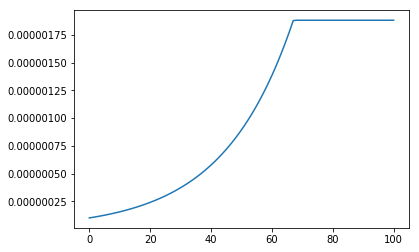

In [3]:
biomass1 = my_comets.total_biomass
plt.plot('cycle', 'iJO1366', data=biomass1)

## Adjusting COMETS parameters in models

What if we want to change some parameters of the model? For instance, we might want to change the type of optimization of the model (objective style) to maximize biomass and then minimize the total flux (parsimonious FBA in cobra terms). For changing such parameters, we need to read the `COBRA` model, and add the corresponding fields for `COMETS`.

In [4]:
import cobra as cb
md = cb.io.read_sbml_model('test_models/iJO1366.xml')

In [5]:
# add some parameters to the model
md.obj_style = 'MAX_OBJECTIVE_MIN_TOTAL'

# change the ID of the model
md.id = 'modified_iJO1366'

If we also want to change $V_{max}$, $K_m$, and Hill coefficients of some uptake reaction, say glucose uptake, we have to add these as fields of the corresponding exchange reaction.  

Moreover, if we change these parameters for any particular reaction, we also need to specify their default values for all the rest of uptake reactions in the model. 

In [6]:
md.reactions.EX_glc__D_e.Vmax = 6
md.reactions.EX_glc__D_e.Km = .1
md.reactions.EX_glc__D_e.Hill = 2

md.default_vmax = 10
md.default_km = 0.01
md.default_hill = 1

Lets now include this cobra model object in our layout. 

Now, we are passing models to the layout as a list of `COBRA` models loaded into the current Python environment, which can also be done in addition to passing them as filenames. 

In [7]:
my_layout.models = [md]
my_layout.models

[<Model modified_iJO1366 at 0x7f3a2b1c59b0>]

As you see, now the layout has a list of models containing cobra models (only one model in this case). 

Note that the list of models in the layout can be either a list of model files (either cobra xml or comets models) or a list of cobra models loaded into the environment, but never a mix of both.  

In order to make effective any changes in the layout models, we have to run `update_models`:

In [8]:
my_layout.update_models()

Now, lets run the new model and compare it to the previous simulation.


Running COMETS simulation ...
Done!


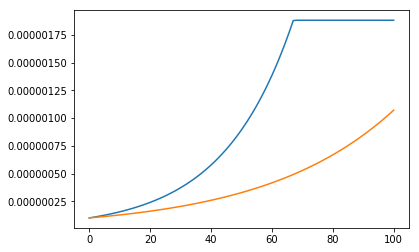

In [9]:
my_comets = c.comets(my_layout, my_params)
my_comets.run()
biomass2 = my_comets.total_biomass
plt.plot('cycle', 'iJO1366', data=biomass1)
plt.plot('cycle', 'modified_iJO1366', data=biomass2)

Makes sense - we made the model worse in glucose by reducing $V_{max}$ and increasing $K_M$.

## Loading COMETS model files
The `layout` class is also capable of loading model files in COMETS model format (`.cmd`, the format passed to the COMETS Java engine). This will be deprecated in the future to simplify things for the user, who will only have to deal with cobra type SBML models.

For example, let's include a `COMETS` model in our previous layout, and run it. 

In [10]:
my_layout.models = ['test_models/iJO1366.cmd']
my_layout.update_models()
my_layout.models

['iJO1366']

In [11]:
my_comets = c.comets(my_layout, my_params)
my_comets.run()


Running COMETS simulation ...
Done!


In [12]:
print(my_comets.run_output)

-script
running script file: /home/djordje/Dropbox/projects/COMETS-Python-Toolbox/.current_script
Loading layout file '/home/djordje/Dropbox/projects/COMETS-Python-Toolbox/.current_layout'...
Found 1 model files!
Loading 'iJO1366.cmd' ...
Loading 'iJO1366.cmd' ...
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Ancestor NO_ANCESTOR
Done!
 Testing default parameters...
Done!
Optimizer status code = 5 (looks ok!)
objective solution = [D@7dc7cbad
Constructing world...
Done!
medialist	12ppd__R_e	12ppd__S_e	14glucan_e	15dap_e	23camp_e	23ccmp_e	23cgmp_e	23cump_e	23dappa_e	26dap__M_e	2ddglcn_e	34dhpac_e	3amp_e	3cmp_e	3gmp_e	3hcinnm_e	3hpp_e	3hpppn_e	3ump_e	4abut_e	4hoxpacd_e	5dglcn_e	5mtr_e	LalaDgluMdapDala_e	LalaDgluMdap_e	LalaDglu_e	LalaLglu_e	ac_e	acac_e	acald_e	acgal1p_e	acgal_e	acgam1p_e	acgam_e	acmana_e	acmum_e	acnam_e	acolipa_e	acser_e	ade_e	adn_e	adocbl_e	ag_e	agm_e	akg_e	ala_B_e	ala__D_e	ala__L_e	alaala_e	all__D_e	alltn_e	amp_e	anhgm_e	ar

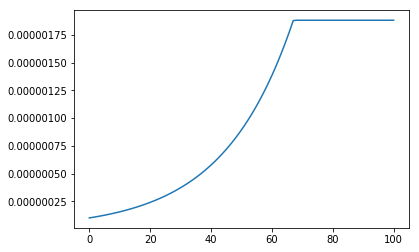

In [13]:
plt.plot('cycle', 'iJO1366', data=my_comets.total_biomass)